In [23]:
import sys
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD
import numpy as np
from numpy import savez_compressed, zeros, asarray, ones
from os import listdir

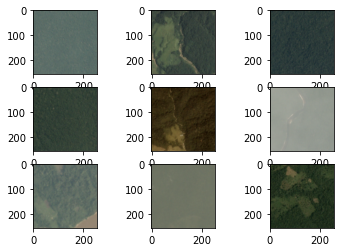

In [2]:
# plot the first 9 images in the planet dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'train-jpg/'
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'train_' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [3]:
import pandas as pd
file = "train_v2.csv/train_v2.csv"
map_data = pd.read_csv(file)

map_data.info()
map_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40479 entries, 0 to 40478
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  40479 non-null  object
 1   tags        40479 non-null  object
dtypes: object(2)
memory usage: 632.6+ KB


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [4]:
# create a mapping of tags to integers given the loaded mapping file
def create_tag_mapping(map_data):
    # create a set of all known tags
    labels = set()
    for i in range(len(map_data)):
        # convert spaced separated tags into an array of tags
        tags = map_data['tags'][i].split(' ')
        # add tags to the set of known labels
        labels.update(tags)
    # convert set of labels to a list to list
    labels = list(labels)
    # order set alphabetically
    labels.sort()
    # dict that maps labels to integers, and the reverse
    labels_map = {labels[i]:i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}
    return labels_map, inv_labels_map

In [5]:
mapping, inv_mapping = create_tag_mapping(map_data)
print(len(mapping))
mapping

17


{'agriculture': 0,
 'artisinal_mine': 1,
 'bare_ground': 2,
 'blooming': 3,
 'blow_down': 4,
 'clear': 5,
 'cloudy': 6,
 'conventional_mine': 7,
 'cultivation': 8,
 'habitation': 9,
 'haze': 10,
 'partly_cloudy': 11,
 'primary': 12,
 'road': 13,
 'selective_logging': 14,
 'slash_burn': 15,
 'water': 16}

In [6]:
# create a mapping of filename to tags
def create_file_mapping(map_data):
    mapping = dict()
    for i in range(len(map_data)):
        name, tags = map_data['image_name'][i], map_data['tags'][i]
        mapping[name] = tags.split(' ')
    return mapping

In [7]:
# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
    # create empty vector
    encoding = zeros(len(mapping), dtype='uint8')
    # mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

In [8]:
# load all images into memory
def load_dataset(path, file_mapping, tag_mapping):
    photos, targets = list(), list()
    # enumerate files in the directory
    for filename in listdir(folder):
        # load image
        photo = load_img(path + filename, target_size=(128,128))
        # convert to numpy array
        photo = img_to_array(photo, dtype='uint8')
        # get tags
        tags = file_mapping[filename[:-4]]
        # one hot encode tags
        target = one_hot_encode(tags, tag_mapping)
        # store
        photos.append(photo)
        targets.append(target)
    X = asarray(photos, dtype='uint8')
    y = asarray(targets, dtype='uint8')
    return X, y

In [9]:
tag_mapping, _ = create_tag_mapping(map_data)
file_mapping = create_file_mapping(map_data)
X, y = load_dataset(folder, file_mapping, tag_mapping)
print(X.shape, y.shape)

# save both arrays to one file in compressed format
savez_compressed('planet_data.npz', X, y)

(40479, 128, 128, 3) (40479, 17)


In [11]:
from numpy import load
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

# load train and test dataset
def load_dataset():
    # load dataset
    data = load('planet_data.npz')
    X, y = data['arr_0'], data['arr_1']
    # separate into train and test datasets
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY

In [14]:
trainX, trainY, testX, testY = load_dataset()

# make all one predictions
train_yhat = asarray([ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = asarray([ones(testY.shape[1]) for _ in range(testY.shape[0])])
# evaluate predictions with sklearn
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones (sklearn): train=%.3f, test=%.3f' % (train_score, test_score))

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


C:\Users\alan0\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


All Ones (sklearn): train=0.484, test=0.484


C:\Users\alan0\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [15]:
from keras import backend

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

# evaluate predictions with keras
train_score = fbeta(backend.variable(trainY), backend.variable(train_yhat))
test_score = fbeta(backend.variable(testY), backend.variable(test_yhat))
print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))

All Ones (keras): train=0.484, test=0.484


In [16]:
# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

In [18]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Fbeta')
    pyplot.plot(history.history['fbeta'], color='blue', label='train')
    pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

In [20]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow(trainX, trainY, batch_size=128)
    test_it = datagen.flow(testX, testY, batch_size=128)
    # define model
    model = define_model()
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=40, verbose=0)
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('&gt; loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    # learning curves
    summarize_diagnostics(history)

In [ ]:
run_test_harness()

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


C:\Users\alan0\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\alan0\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
